# Data preparation

In [2]:
from datasets import load_from_disk

def new_column(example):
    example["ner_tags"] = example["labels"]
    return example

data = load_from_disk("dataset.hf")
id_column = range(data.num_rows)
data = data.add_column("id", id_column)
data = data.map(new_column)

# Split up the data for testing and training
data = data.train_test_split(test_size=0.1)
test_data = data["test"]
data = data["train"].train_test_split(test_size=0.2)

print(data, test_data)

Loading cached processed dataset at /mnt/c/Users/perry/Documents/uni/Master/CompSem/project/ComputationalSemantics/dataset.hf/cache-cf6e09deaae4883c.arrow


DatasetDict({
    train: Dataset({
        features: ['tokens', 'labels', 'origin', 'id', 'ner_tags'],
        num_rows: 6654
    })
    test: Dataset({
        features: ['tokens', 'labels', 'origin', 'id', 'ner_tags'],
        num_rows: 1664
    })
}) Dataset({
    features: ['tokens', 'labels', 'origin', 'id', 'ner_tags'],
    num_rows: 925
})


In [3]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

example = data["train"][0]
tokenized_input = tokenizer(example["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
tokens

['[CLS]', 'she', 'married', 'an', 'american', '.', '[SEP]']

In [4]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx]) # Label all tokens of a given word
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_data = data.map(tokenize_and_align_labels, batched=True)
tokenized_test_data = test_data.map(tokenize_and_align_labels, batched=True)
tokenized_data["train"][0]

Map:   0%|          | 0/6654 [00:00<?, ? examples/s]

Map:   0%|          | 0/1664 [00:00<?, ? examples/s]

Map:   0%|          | 0/925 [00:00<?, ? examples/s]

{'tokens': ['She', 'married', 'an', 'American', '.'],
 'labels': [-100, 2, 0, 0, 0, 0, -100],
 'origin': [1.1, None, 1.0, 1.0, None],
 'id': 6433,
 'ner_tags': [2, 0, 0, 0, 0],
 'input_ids': [101, 2016, 2496, 2019, 2137, 1012, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [5]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

## Evaluation method

In [6]:
def filter_and_group_lists(first_list, second_list):
    result_first = []
    result_second = []
    previous_value = None
    current_group = []

    for value1, value2 in zip(first_list, second_list):
        if value1 != -100 and value1 != 0:
            if value1 != previous_value:
                if current_group:
                    result_second.append(current_group)
                current_group = [value2]
                result_first.append(value1)
            else:
                current_group.append(value2)
        previous_value = value1

    if current_group:
        result_second.append(current_group)

    return result_first, result_second

first_list = [-100, 2, 0, 1, 1, 0, 0, 2, 0, 1, 2, -100]
second_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']

filtered_first, grouped_second = filter_and_group_lists(first_list, second_list)
print("Filtered First List:", filtered_first)
print("Grouped Second List:", grouped_second)


Filtered First List: [2, 1, 2, 1, 2]
Grouped Second List: [['B'], ['D', 'E'], ['H'], ['J'], ['K']]


In [7]:
import numpy as np

def getFinalPrediction(predictions):
    predictions = np.array(predictions)
    non_zero_predictions = predictions[predictions != 0]
    counts = np.bincount(non_zero_predictions)
    if counts.size == 0:
        return 1
    return np.argmax(counts)

print(getFinalPrediction([1, 2, 2, 3, 0, 4, 9, 9, 9]))

9


In [8]:
import evaluate
import numpy as np

seqeval = evaluate.load("seqeval")

#mapping = {"Theme": 1, "Agent": 2, "Patient": 3, "Experiencer": 4, "Co-Theme": 5, "Stimulus": 6, "Location": 7, "Destination": 8}
label_list = [
    "O",
    "Theme",
    "Agent",
    "Patient",
    "Experiencer",
    "Co-Theme",
    "Stimulus",
    "Location",
    "Destination",
]

labels = [label_list[i] for i in example[f"ner_tags"]]

def getTrueLabelsAndPredictions(labels, predictions):
    true_labels = []
    true_predictions = []
    for label, prediction in zip(labels, predictions):
        true_label, grouped_predictions = filter_and_group_lists(label, prediction)

        true_labels.append([label_list[l] for l in true_label])
        true_prediction = list(map(getFinalPrediction, grouped_predictions))

        true_predictions.append([label_list[p] for p in true_prediction])
    
    return true_labels, true_predictions

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    
    true_labels, true_predictions = getTrueLabelsAndPredictions(labels, predictions)

#     print(sum(len(x) for x in true_labels))
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# Training

In [9]:
mapping = {"Theme": 1, "Agent": 2, "Patient": 3, "Experiencer": 4, "Co-Theme": 5, "Stimulus": 6, "Location": 7, "Destination": 8}

label2id = {"O": 0}
label2id.update(mapping)
id2label = {v: k for k, v in label2id.items()}
print(id2label)
print(label2id)

{0: 'O', 1: 'Theme', 2: 'Agent', 3: 'Patient', 4: 'Experiencer', 5: 'Co-Theme', 6: 'Stimulus', 7: 'Location', 8: 'Destination'}
{'O': 0, 'Theme': 1, 'Agent': 2, 'Patient': 3, 'Experiencer': 4, 'Co-Theme': 5, 'Stimulus': 6, 'Location': 7, 'Destination': 8}


In [10]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=9, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream

In [10]:
# Training parameters
training_args = TrainingArguments(
    output_dir="thematic_role_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=4,
#     load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/home/perrygast/.local/lib/python3.8/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.283054,0.889073,0.874237,0.881592,0.889384


/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Agent seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Patient seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Theme seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Co-Theme seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Location seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/perryg

KeyboardInterrupt: 

# Test on separate part of the dataset

In [11]:
trained_model = AutoModelForTokenClassification.from_pretrained("thematic_role_model/checkpoint-832")
testing_args = TrainingArguments(
    output_dir="./eval_output",
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    eval_steps=100,  # Adjust as needed
)
trainer = Trainer(
    model=trained_model,
    args=testing_args,
    train_dataset=None,
    eval_dataset=tokenized_test_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.evaluate()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Agent seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Theme seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Patient seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Destination seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Location seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/per

{'eval_loss': 0.15748222172260284,
 'eval_precision': 0.9381294964028777,
 'eval_recall': 0.9281138790035587,
 'eval_f1': 0.9330948121645795,
 'eval_accuracy': 0.9389638041163946,
 'eval_runtime': 4.6254,
 'eval_samples_per_second': 199.985,
 'eval_steps_per_second': 25.079}

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

raw_test_predictions = trainer.predict(tokenized_test_data)

/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Agent seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Theme seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Patient seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Destination seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/perrygast/.local/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Location seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/per

<Figure size 432x288 with 0 Axes>

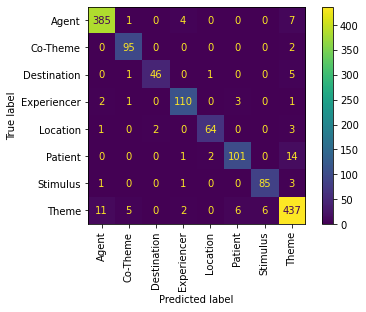

In [21]:
def flatten(xss):
    return [x for xs in xss for x in xs]

test_predictions = np.argmax(raw_test_predictions.predictions, axis=2)
true_test_labels, true_test_predictions = getTrueLabelsAndPredictions(tokenized_test_data['labels'], test_predictions)
true_test_labels = flatten(true_test_labels)
true_test_predictions = flatten(true_test_predictions)
plt.clf()
fig, ax = plt.subplots()

matrix = ConfusionMatrixDisplay.from_predictions(y_true = true_test_labels, 
                                                 y_pred = true_test_predictions,
                                                 xticks_rotation = 'vertical',
                                                 ax = ax)


plt.savefig("confusion.png", dpi = 600, bbox_inches='tight')

# Inference
This block performs inference on a given sentence. Note that it returns a label per Bert token. There is always a special token at the beginning and end of each sentence. The predicted labels for these tokens have been removed. For most simple sentences, one word corresponds to one Bert token.

In [21]:
import torch
from transformers import AutoTokenizer

# text = "I deserve to know the truth."
text = "Tom didn't know when Mary had come to Boston."

tokenizer = AutoTokenizer.from_pretrained("thematic_role_model/checkpoint-832")
inputs = tokenizer(text, return_tensors="pt")

from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("thematic_role_model/checkpoint-832")
with torch.no_grad():
    logits = model(**inputs).logits

predictions = torch.argmax(logits, dim=2)
predicted_token_class = [model.config.id2label[t.item()] for t in predictions[0]]

print(text)
print(predicted_token_class[1:-1])

Tom didn't know when Mary had come to Boston.
['Experiencer', 'O', 'O', 'O', 'O', 'O', 'Theme', 'O', 'O', 'O', 'Destination', 'O']
